Dans cette partie, nous allons tenter de construire un modèle permettant de prédire si un vin a obtenu une bonne note ou une mauvaise. Pour cela nous allons évaluer plusieurs modèles. Puis nous procédrons à des transformations sur le jeu de donnée et optimiserons les modèles afin d'afinner les prédictions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')
df = data.copy()
df.shape

(1599, 12)

Il est important d'effectuer une copie du jeu de donnée afin de le garder tel qu'il est. Tout les recherches seront effectuer sur sa copie.

# Preprocessing

Nous allons séparer le jeu de données en deux, soit un jeu d'entrainement et un jeu de test. Le jeu de test ne sera utilisé qu'à la toute fin pour ne pas biaiser les résultats.

In [2]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size=0.25, random_state=0)

5    512
6    468
7    159
4     39
8     13
3      8
Name: quality, dtype: int64

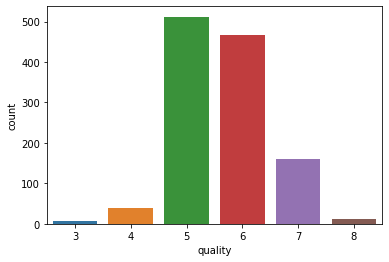

In [3]:
sns.countplot(x='quality', data=trainset);
trainset.quality.value_counts()

6    170
5    169
7     40
4     14
8      5
3      2
Name: quality, dtype: int64

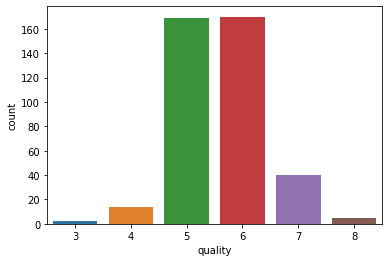

In [4]:
sns.countplot(x='quality', data=testset);
testset.quality.value_counts()

La répartition des classes au sein du trainset et du testset est bien similaire.

À présent construisons une fonction permmettant de traiter le jeu de données afin de préparer la phase d'apprentisage. Le jeu de donnée, étant uniquement constitué de variables numériques et n'ayant pas de valeurs manquantes, ne nécéssite pas beaucoup de transformations.
Dans un premier temps, nous affectons à $X$ les colonnes des variables et à $y$ la colonne objectif `df['good_wine']` telle que:  `df['good_wine'] = df.quality > 6.5`.

In [5]:
def preprocessing(df):
    df['good_wine'] = df.quality > 6.5
    X = df.drop(['quality', 'good_wine'], axis=1)
    y = df['good_wine']
    print(y.value_counts())
    return X, y

In [6]:
X_train, y_train = preprocessing(trainset)

False    1027
True      172
Name: good_wine, dtype: int64


In [7]:
X_test, y_test = preprocessing(testset)

False    355
True      45
Name: good_wine, dtype: int64


# Procédure d'évaluation

Il est important de décider dès à présent les modalités de la procédure d'évaluation des modèles. Cela permettera de les comparer de manière objective. Pour ce faire, on décide de prendre comme métrique le score $F_1$ tel que
$$
F_1 = 2  * \frac{spécificité * sensibilité}{spécificité + sensibilité}
$$
avec
$$sensibilité =  \frac{TP}{TP+FN}$$
et 
$$spécificité = \frac{TN}{TN+FP}$$

On aussi choisit de prendre le score `f_weighted`. Ce score calcule les scores $F_1$ pour chaque étiquette, et trouve leur moyenne pondérée par le support (le nombre d'instances vraies pour chaque étiquette). Cela modifie le score pour prendre en compte le déséquilibre des étiquettes; cela peut donner un score $F_1$ qui ne se situe pas entre la précision et le rappel.

On utilise aussi la courbe d'apprentissage, learning curve en anglais, qui nous donne des informations essentielles sur l'état d'apprentissage du modèle: surapprentissage ou bien en sous-apprentissage.

Nous afficherons aussi à titre indicatif le score ROC AUC mais cet indicateur ne sera pas décisif dans le choix du modèle.

In [8]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import f1_score, roc_auc_score, plot_roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

def evaluation(X_train, y_train, model, display_graph=False):
    
    cv = StratifiedKFold(n_splits=4)
    
    y_pred = cross_val_predict(model,
                              X_train,
                              y_train,
                              cv = cv)
    
    score = f1_score(y_train, y_pred)
    score_w = f1_score(y_train, y_pred, average='weighted')
    score_auc = roc_auc_score(y_train, y_pred)
    
    cm = confusion_matrix(y_train, y_pred)
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                               cv = cv,
                                               scoring = 'f1_weighted',
                                               train_sizes = np.linspace(0.1, 1, 10))
    
    if display_graph:
        print(f'{model[-1].__class__.__name__}')
        print(f'F_1: {round(score,3)}, F_1 weighted: {round(score_w,3)}, AUC: {round(score_auc,3)}')
        fig, ax = plt.subplots(1, 2, figsize = (11,4))
        fig.subplots_adjust(top=0.80)
        # Confusion matrix
        ax[0].set_title('Confusion matrix')
        cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues', ax=ax[0])
        # Learning curve with F1 score
        ax[1].set_title('Learning curve')
        ax[1].plot(N, train_score.mean(axis=1), label='train score')
        ax[1].plot(N, val_score.mean(axis=1), label='validation score')

        plt.suptitle(model[-1].__class__.__name__, fontsize=14)
        plt.legend()
        plt.show()
    
    return score, score_w, score_auc

# Modélisation

Testons à présent, de manière rapide et sans optimisation, plusieurs modèles afin de retenir quelques-uns des plus prometteurs. Pour se faire, nous allons utiliser des pipelines permmettant dans cette partie d'initialiser les modèles. Cet outils sera utile par la suite pour améliorer/tuner les modèles d'apprentissage.

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

In [10]:
RandomForest = make_pipeline(RandomForestClassifier(random_state=0))
SVM = make_pipeline(StandardScaler(), SVC(random_state=0))
KNN = make_pipeline(StandardScaler(), KNeighborsClassifier())
GBClassifier = make_pipeline(StandardScaler(), GradientBoostingClassifier(random_state=0))
GaussianNB = make_pipeline(StandardScaler(), GaussianNB())
MLPClassifier = make_pipeline(StandardScaler(),MLPClassifier(random_state=0))

dict_of_models = {'RandomForest':RandomForest,
                  'GBoost':GBClassifier,
                  'SVM':SVM,
                  'KNN':KNN,
                  'NaiveBayes':GaussianNB,
                  'MLPClassifier':MLPClassifier
                 }

RandomForestClassifier
F_1: 0.556, F_1 weighted: 0.887, AUC: 0.71


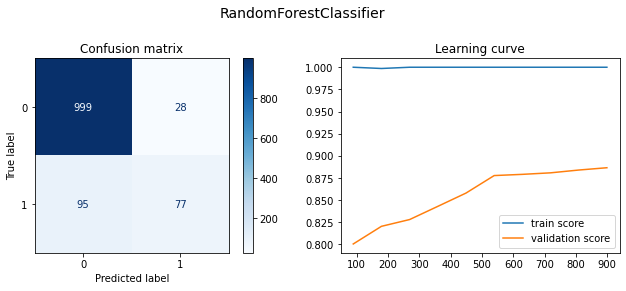

GradientBoostingClassifier
F_1: 0.48, F_1 weighted: 0.867, AUC: 0.675


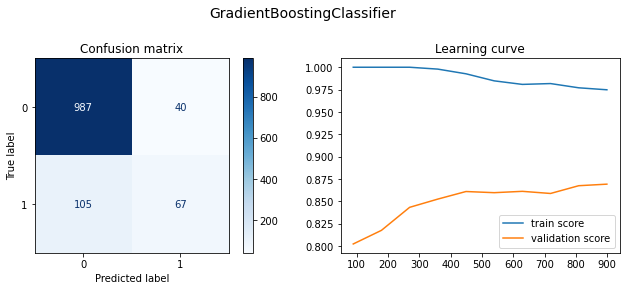

SVC
F_1: 0.397, F_1 weighted: 0.853, AUC: 0.631


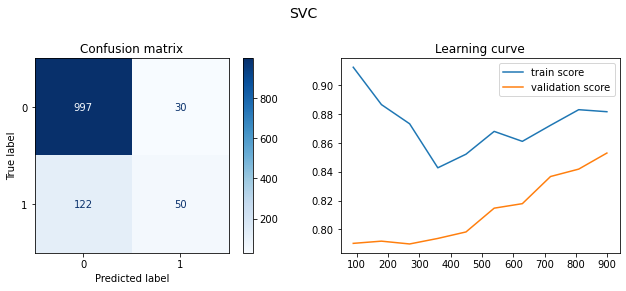

KNeighborsClassifier
F_1: 0.488, F_1 weighted: 0.859, AUC: 0.693


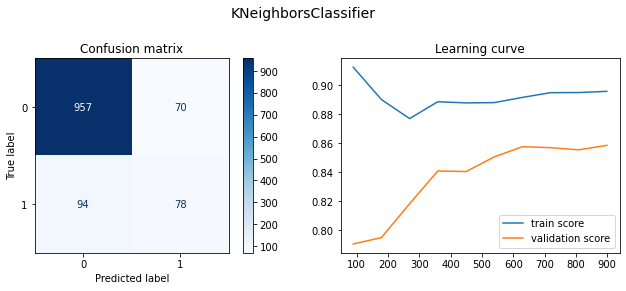

GaussianNB
F_1: 0.512, F_1 weighted: 0.841, AUC: 0.745


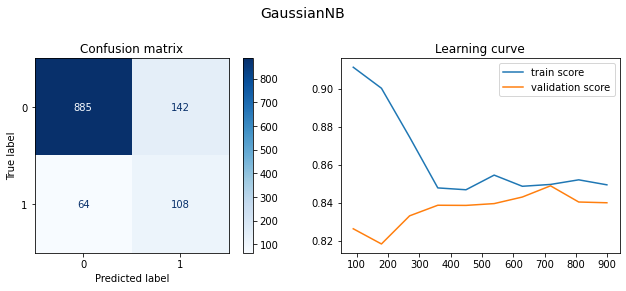

MLPClassifier
F_1: 0.458, F_1 weighted: 0.859, AUC: 0.668


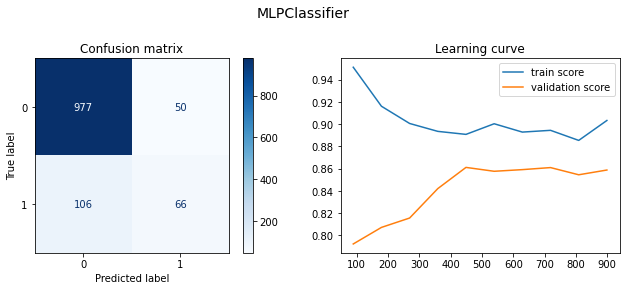

,Score F1,Score F1 weighted,Score AUC
RandomForest,0.56,0.89,0.710205
GBoost,0.48,0.87,0.675293
KNN,0.49,0.86,0.692664
MLPClassifier,0.46,0.86,0.667518
SVM,0.40,0.85,0.630743
NaiveBayes,0.51,0.84,0.744820


In [11]:
scores_f1 = []
scores_f1_weighted = []
scores_auc = []
for name, model in dict_of_models.items():
    score, score_w, score_auc = evaluation(X_train, y_train, model, display_graph=True)
    scores_f1.append(score)
    scores_f1_weighted.append(score_w)
    scores_auc.append(score_auc)

res = pd.DataFrame({'Score F1':np.round(scores_f1,2),
                    'Score F1 weighted':np.round(scores_f1_weighted,2),
                    'Score AUC':scores_auc},
                   index=dict_of_models.keys())
display(res.sort_values(by=['Score F1 weighted','Score F1'], ascending=False))

Nous pouvons voir que le meilleur modèle est le `RandomForest`. En effet, ce modèle bat la très grande majorité des autres modèle sur les trois indicateurs.

# Optimisation

Nous allons dans cette partie essayer de selectionner les meilleurs variables ainsi qu'optimiser les modèles `RandomForest` et `KNN`.

## Feature engineering

Observons l'importance des variables au sein du modèle `RandomForest`.

<Figure size 432x288 with 0 Axes>

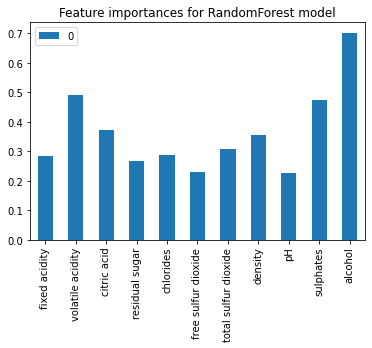

In [12]:
cross_validate
rf_estimators = cross_validate(RandomForest,
                            X_train,
                            y_train,
                            cv=StratifiedKFold(4),
                            scoring='f1_weighted',
                            return_estimator=True)['estimator']
    
feature_importances = np.zeros(len(X_train.columns))
for estimator in rf_estimators:
    feature_importances += estimator[-1].feature_importances_

plt.figure()
pd.DataFrame(feature_importances, index=X_train.columns).plot.bar()
plt.title('Feature importances for RandomForest model');

Aucune variable ne semble à priori à exclure impérativement. On remarque cependant que la variable `alcohol` est une variable ayant beaucoup d'influence à l'instar de la variable `volatile acidity`. On retrouve donc les variables ayant les plus forte corrélations.

Peu de variables sont présentes dans notre dataset. De plus les courbes d'apprentissage des modèles `RandomForest` et `KNN` ne semble pas avoir atteint leur plateau sur la courbe du validation set, cela est un signe d'underfitting. Augmenter le degré des variables permettera peut-être de trouver un juste millieu entre underfitting et overfitting pour nos modèles.

In [13]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
X_train_poly = pd.DataFrame(poly.fit_transform(X_train))
print(X_train_poly.shape)

(1199, 78)


### Select K Best

La sélection de caractéristiques univariées consiste à sélectionner les meilleures caractéristiques sur la base de tests statistiques univariés. Le test considéré dans notre est l'ANOVA.

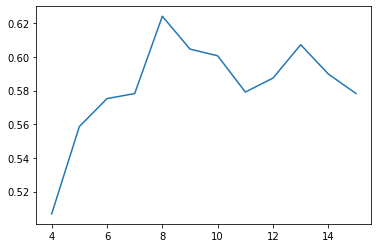

In [14]:
from sklearn.feature_selection import SelectKBest, f_classif
f1_scores = []
for k in range(4,16):
    model = RandomForestClassifier(random_state=0)
    selector_kbest = make_pipeline(SelectKBest(f_classif, k=k), model)
    f1_scores.append(evaluation(X_train_poly, y_train, selector_kbest)[0])
plt.plot(range(4,16), f1_scores);

Pour cette méthode, les meilleurs résultats sont obtenus lorsque nous prenons les 8 meilleures variables.

### Select From Model

SelectFromModel est un méta-transformateur qui peut être utilisé avec n'importe quel estimateur qui attribue une importance à chaque caractéristique par le biais d'un attribut spécifique (tel que coef_, feature_importances_) ou via un importance_getter appelable après l'ajustement. Les caractéristiques sont considérées comme non importantes et supprimées si l'importance correspondante des valeurs des caractéristiques est inférieure au paramètre de seuil fourni. En plus de spécifier le seuil numériquement, il existe des heuristiques intégrées pour trouver un seuil en utilisant un argument de type chaîne. Les heuristiques disponibles sont "moyenne", "médiane" et des multiples flottants de ceux-ci comme "0.1*moyenne".

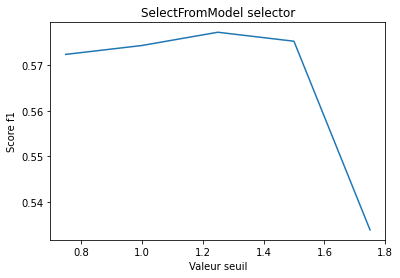

In [15]:
from sklearn.feature_selection import SelectFromModel
f1_scores = []
x = np.arange(0.75, 2, 0.25)
for k in x:
    selector_sfm = SelectFromModel(RandomForestClassifier(random_state=0), threshold=f'{k}*mean')
    selector_sfm.fit_transform(X_train_poly, y_train)
    X_train_sfm = X_train_poly[X_train_poly.columns[selector_sfm.get_support()]]
    f1_scores.append(evaluation(X_train_sfm, y_train, RandomForest)[0])
plt.plot(x, f1_scores)
plt.xlabel('Valeur seuil')
plt.ylabel('Score f1')
plt.title('SelectFromModel selector');

Les meilleurs résultat sont obtenus pour une valeur seuil correspondant à 1,25 fois la moyenne.

### PCA

L'ACP est utilisée pour décomposer un ensemble de données multivariées en un ensemble de composantes orthogonales successives qui expliquent une quantité maximale de la variance. Dans scikit-learn, l'ACP est implémentée comme un objet transformateur qui apprend les composantes dans sa méthode d'ajustement, et peut être utilisée sur de nouvelles données pour les projeter sur ces composantes.

L'ACP centre mais ne met pas à l'échelle les données d'entrée pour chaque caractéristique avant d'appliquer le SVD. Le paramètre optionnel whiten=True permet de projeter les données sur l'espace singulier tout en mettant à l'échelle chaque composante à la variance unitaire.

In [16]:
from sklearn.decomposition import PCA
model = RandomForestClassifier(random_state=0)
selector_pca = make_pipeline(PCA(10,whiten=True), model)
evaluation(X_train, y_train, selector_pca)

(0.5421245421245421, 0.8839313232189648, 0.7019711963044315)

### PLS

PLS présente des similitudes avec la régression en composantes principales (PCR), où les échantillons sont d'abord projetés dans un sous-espace de dimension inférieure, et les cibles y sont prédites en utilisant transformé(X). Un problème avec la PCR est que la réduction de la dimensionnalité n'est pas supervisée et peut perdre certaines variables importantes : La PCR conserve les caractéristiques ayant la plus grande variance, mais il est possible que les caractéristiques ayant une faible variance soient pertinentes pour prédire la cible. D'une certaine manière, PLS permet le même type de réduction de la dimensionnalité, mais en prenant en compte les cibles y.

In [17]:
from sklearn.cross_decomposition import PLSSVD
model = RandomForestClassifier(random_state=0)
pls = PLSSVD(n_components=10).fit(X_train, y_train)
X_pls = pls.transform(X_train)
evaluation(X_pls, y_train, model)

(0.4307692307692308, 0.8419016787370058, 0.6630794139625461)

### Bilan

La méthode ayant obtenu les meilleures résultat est la méthode PolynomialFeature associé aux sélecteur SelectKBest. Nous allons donc intégrer ces traitement à la nouvelle pipeline.

In [18]:
def preprocessing(df):
    df['good_wine'] = df.quality > 6.5
    X = df.drop(['quality', 'good_wine'], axis=1)
    y = df['good_wine']
    X = SelectKBest(f_classif, k=8).fit_transform(X, y)
    return X, y

X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

## Hyperparamètres

### RandomForest

Une forêt aléatoire est un méta-estimateur qui ajuste un certain nombre de classificateurs d'arbres de décision sur divers sous-échantillons de l'ensemble de données et utilise la moyenne pour améliorer la précision prédictive et contrôler l'ajustement excessif.

In [19]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
score = 'f1_weighted'

In [20]:
params_rf = {
    'randomforestclassifier__class_weight':['balanced'],
    'randomforestclassifier__criterion' :['entropy','gini'],
    'randomforestclassifier__n_estimators':[50,100,200,400,600,800],
    'randomforestclassifier__max_depth':[None,3,6,10,14,18]
}
grid_rf = RandomizedSearchCV(RandomForest, params_rf, scoring=score, cv=StratifiedKFold(4), n_iter=20)
grid_rf.fit(X_train, y_train)
print('Best params_rf:',grid_rf.best_params_)
print('\nBest score:', grid_rf.best_score_)

Best params_rf: {'randomforestclassifier__n_estimators': 50, 'randomforestclassifier__max_depth': 14, 'randomforestclassifier__criterion': 'gini', 'randomforestclassifier__class_weight': 'balanced'}

Best score: 0.8943611529797854


In [21]:
evaluation(X_train, y_train, grid_rf.best_estimator_)

(0.5951557093425606, 0.8944056601825194, 0.7349074975657254)

### GBClassifier

Le boosting de gradient est une technique d'apprentissage automatique pour les problèmes de régression et de classification, qui produit un modèle de prédiction sous la forme d'un ensemble de modèles de prédiction faibles, généralement des arbres de décision. Elle construit le modèle par étapes, comme le font les autres méthodes de boosting, et elle les généralise en permettant l'optimisation d'une fonction de perte différentiable arbitraire.

In [46]:
params_gb={
    "gradientboostingclassifier__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
    "gradientboostingclassifier__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
    #"gradientboostingclassifier__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    #"gradientboostingclassifier__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]  
}
grid_gb = RandomizedSearchCV(GBClassifier, params_gb, scoring=score, cv=4, n_iter=100)
#print(grid_gb.get_params().keys())
grid_gb.fit(X_train, y_train)
print('Best params_xgb:',grid_gb.best_params_)
print('\nBest score:', grid_gb.best_score_)

Best params_xgb: {'gradientboostingclassifier__max_depth': 8, 'gradientboostingclassifier__learning_rate': 0.2}

Best score: 0.8909835271287253


In [47]:
evaluation(X_train, y_train, grid_gb.best_estimator_)

(0.5841924398625429, 0.891161744491215, 0.7305399560698354)

## SVM

In [ ]:
# params_svc = {
#     'svc__class_weight':['balanced', None],
#     'svc__C':[10,50,100,250,500,750,1500]
# }
# grid_svm = GridSearchCV(SVM, params_svc, scoring=score, cv=4)
# grid_svm.fit(X_train, y_train)
# print('Best params_svc:',grid_svm.best_params_)
# print('\nBest score:', grid_svm.best_score_)

In [ ]:
# evaluation(X_train, y_train, grid_svm.best_estimator_)

### KNN

La classification basée sur les plus proches voisins est un type d'apprentissage basé sur les instances ou apprentissage non généralisateur : elle ne tente pas de construire un modèle interne général, mais stocke simplement les instances des données d'apprentissage. La classification est calculée à partir d'un simple vote majoritaire des voisins les plus proches de chaque point : un point d'interrogation se voit attribuer la classe de données qui a le plus de représentants parmi les voisins les plus proches du point.

In [48]:
params_knn = {
    'kneighborsclassifier__weights':['distance', 'uniform'],
    'kneighborsclassifier__n_neighbors':list(range(1,25))
}
grid_knn = GridSearchCV(KNN, params_knn, scoring=score)
grid_knn.fit(X_train, y_train)
print('Best params_knn:',grid_knn.best_params_)
print('\nBest score:', grid_knn.best_score_)

Best params_knn: {'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__weights': 'distance'}

Best score: 0.8900374251517217


In [49]:
evaluation(X_train, y_train, grid_knn.best_estimator_)

(0.5723684210526315, 0.8854787416263331, 0.7309985054686261)

# Precision Recall Curve

Il est intéressant de pourvoir avoir un impact sur le modèle concernant ses scores de spécificité et précision. En effet, on pourrait avoir envie de prioriser un indicateur plutôt qu'un autre. La courbe précision-rappel nous permet de faire cela en visualisant .

Dans notre cas, prioriser le rappel (= la sensibilité) revient à vouloir détecter un maximum de vins avec une bonne note quitte à y inclure plus de vins ayant une mauvaise note. À l'inverse prioriser la précision revient à minimiser le taux de faux négatifs. En contrepartie, on détectera moins de vins ayant une bonne note.

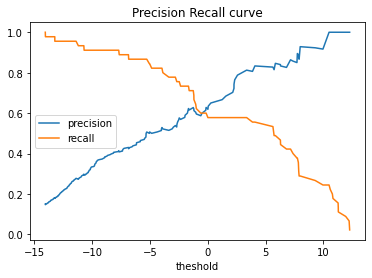

In [50]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve(y_test, grid_gb.best_estimator_.decision_function(X_test))
plt.plot(threshold, precision[:-1], label='precision')
plt.plot(threshold, recall[:-1], label='recall')
plt.xlabel('theshold')
plt.legend()
plt.title('Precision Recall curve');

In [51]:
def model_final(model, X, threshold):
    return model.decision_function(X) > threshold

Ainsi, si nous souhaitons un compromis entre la précision et le rappel, il faut choisir la valeur pour laquelle les courbes s'intersectent. Puis nous pouvons construire notre modèle final afin d'obtenir le score final.

In [53]:
from sklearn.metrics import f1_score
y_pred = model_final(grid_gb.best_estimator_, X_test, 0)
f1_score_val = f1_score(y_test, y_pred)
f1_w_score = f1_score(y_test, y_pred, average='weighted')
roc_auc_score = f1_score(y_test, y_pred, average='weighted')
print("Final scores:")
print(f"F1: {f1_score_val}, F1_weighted: {f1_w_score}, ROC AUC: {roc_auc_score}")

TypeError: 'numpy.float64' object is not callable

# Bilan de la classification

Nous avons donc réussi à obtenir un score de pour le modèle final ce qui peut être considéré comme relativement bon.